# Introduction to Deep Learning Training
In this notebook you will learn how to make in a few lines of code a model that distinguises cats from dogs in pictures, using the [fastai](https://docs.fast.ai/) library.

## Disclaimer
This is widely based on the [fastbook](https://github.com/fastai/fastbook) created by [Jeremy Howard](https://github.com/jph00) and [Sylvain Grugger](https://github.com/sgugger). Lot's of code samples and text snippets are taken from the fastbook as it is a great ressource and I just took some bits left and right and adapted them slightly to give you a first intro, but I really recommend if you are interested to follow it yourself in more details.

## Install
In kaggle the fastai library is already pre installed so you don't need to install it

Also make sure that you select, before running any cell, the GPU backend by going to the ‘Settings’ tab and in 'Environment’ and select ‘GPU P100’. As you will see you only get 30 hours of GPU per week. However, this should be more than enough for this training. If you want to be sure you can also switch back to a CPU once you have finished the model training part, however make sure that you saved your model before as when you switch to CPU it will restart the kernel and all you variables and executions will be lost (except if you in persistence chose to persit the variables).


In the cell below you will find a complete system for creating and training a state-of-the-art model for recognizing cats versus dogs. So, let's train it now! To do so, just press Shift-Enter on your keyboard, or press the Play button on the toolbar. Then wait a few minutes while the following things happen:

1. A dataset called the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) that contains 7,349 images of cats and dogs from 37 different breeds will be downloaded from the fast.ai datasets collection to the GPU server you are using, and will then be extracted.
2. A *pretrained model* that has already been trained on 1.3 million images, using a competition-winning model will be downloaded from the internet.
3. The pretrained model will be *fine-tuned* using the latest advances in transfer learning, to create a model that is specially customized for recognizing dogs and cats. It will run two epochs, one only on 

The first two steps only need to be run once on your GPU server. If you run the cell again, it will use the dataset and model that have already been downloaded, rather than downloading them again. Let's take a look at the contents of the cell, and the results

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'  # downloads the data

def is_cat(x): return x[0].isupper()  # label function (if uppercase it is a cat, otherwise it is a dog)

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))  # data loader

learn = cnn_learner(dls, resnet34, metrics=error_rate)  # our CNN model
learn.fine_tune(1)  # training of the model

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/model

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.157393,0.027582,0.010825,00:53


epoch,train_loss,valid_loss,error_rate,time
0,0.066344,0.024807,0.007442,00:53


Now let's have a look at what happened in a bit more details and how we can make sure our model actually works that well. The first line will download and decompress the dataset. It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the .ls() method.


In [2]:
path = untar_data(URLs.PETS)/'images'  # won't redownload the data
path.ls()  # show where it is saved and some paths

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')...]

get_image_files is a fastai function that helps us grab all the image files (recursively) in one folder.

In [3]:
files = get_image_files(path)
len(files)  # how many images do we have

7390


### Cats vs dogs

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs:

In [7]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'))

This is why we defined our label function as follows:


In [8]:
def is_cat_(x): return x[0].isupper()  # label function (if uppercase it is a cat, otherwise it is a dog)

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`. 

In [9]:
dls = ImageDataLoaders.from_name_func(path, files, valid_pct=0.2, seed=42,
                                      label_func=is_cat, item_tfms=Resize(224))

There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

The other important piece of information that we have to tell fastai is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename, or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we're telling fastai to use the `is_cat` function we just defined.

Finally, we define the `Transform`s that we need. A `Transform` contains code that is applied automatically during training; fastai includes many predefined `Transform`s, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item (in this case, each item is resized to a 224-pixel square), while `batch_tfms` are applied to a *batch* of items at a time using the GPU, so they're particularly fast (we'll see many examples of these throughout this course).

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass pretty much anything. If you increase the size, you'll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; the opposite is true if you decrease the size. 

The most important parameter to mention here is `valid_pct=0.2`. This tells fastai to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

fastai will *always* show you your model's accuracy using *only* the validation set, *never* the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on *previously unseen images*. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

Even when your model has not fully memorized all your data, earlier on in training it may have memorized certain parts of it. As a result, the longer you train for, the better your accuracy will get on the training set; the validation set accuracy will also improve for a while, but eventually it will start getting worse as the model starts to memorize the training set, rather than finding generalizable underlying patterns in the data. When this happens, we say that the model is *overfitting*.

We can then check if everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

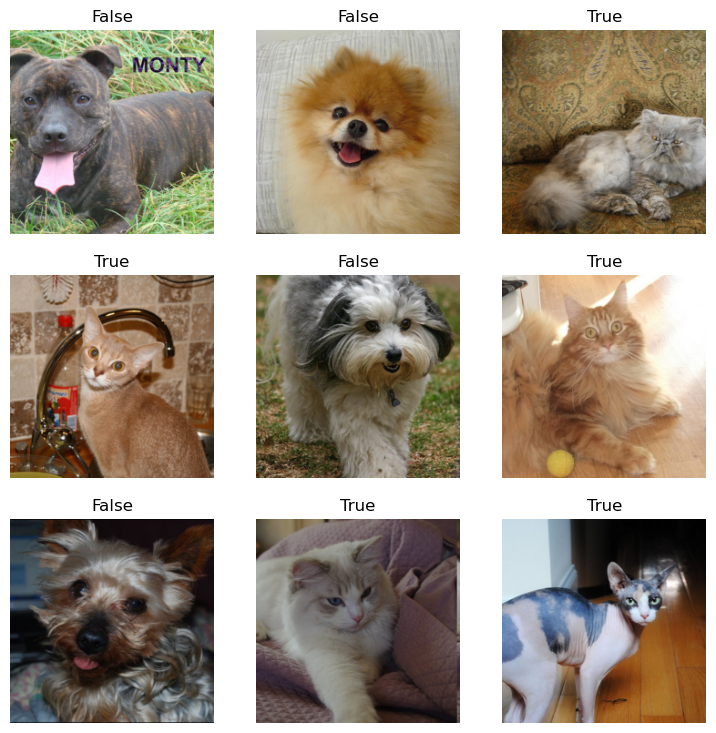

In [10]:
dls.show_batch()

The fifth line of the code training our image recognizer tells fastai to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = cnn_learner(dls, resnet34, metrics=error_rate)
```

Why a CNN? It's the current state-of-the-art approach to creating computer vision models. 

There are many different architectures in fastai. Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called _ResNet_ that we'll be talking a lot about during the course; it is both fast and accurate for many datasets and problems. The `34` in `resnet34` refers to the number of layers in this variant of the architecture (other options are `18`, `50`, `101`, and `152`). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

`cnn_learner` also has a parameter `pretrained`, which defaults to `True` (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous [*ImageNet* dataset](http://www.image-net.org/)). A model that has weights that have already been trained on some other dataset is called a *pretrained model*. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

When using a pretrained model, `cnn_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the *head*.

Using pretrained models is the *most* important method we have to allow us to train more accurate models, more quickly, with less data, and less time and money. Using a pretrained model for a task different to what it was originally trained for is known as *transfer learning*. Unfortunately, because transfer learning is so under-studied, few domains have pretrained models available. For instance, there are currently few pretrained models available in medicine, making transfer learning challenging to use in that domain. In addition, it is not yet well understood how to use transfer learning for tasks such as time series analysis.

The sixth line of our code tells fastai how to *fit* the model:

```python
learn.fine_tune(1)
```

As we've discussed, the architecture only describes a *template* for a mathematical function; it doesn't actually do anything until we provide values for the millions of parameters it contains.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of *epochs*). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called `fine_tune`, and not `fit`? fastai actually *does* have a method called `fit`, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. As you'll learn, there are some important tricks to adapt a pretrained model for a new dataset—a process called *fine-tuning*.

When you use the `fine_tune` method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
1. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).

The *head* of a model is the part that is newly added to be specific to the new dataset. An *epoch* is one complete pass through the dataset. After calling `fit`, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any *metrics* you've requested (error rate, in this case).

### Saving our model
Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [11]:
learn.export('/kaggle/working/export.pkl')

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [12]:
path = Path('/kaggle/working')
path.ls(file_exts='.pkl')

(#1) [Path('/kaggle/working/export.pkl')]

In the Kaggle notebooks you will notice that there is a third option in the “Add Data” modal: Notebook Output Files.

Up to 20 GBs of output from a Notebook may be saved to disk in /kaggle/working. This data is saved automatically and you can then reuse that data in any future Notebook: just navigate to the “Data” pane in a Notebook editor, click on “Add Data”, click on the "Notebook Output Files" tab, find a Notebook of interest, and then click to add it to your current Notebook.

By chaining Notebooks as data sources in this way, it’s possible to build pipelines and generate more and better content than you could in a single notebook alone.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [13]:
learn_inf = load_learner('/kaggle/working/export.pkl')

### Testing our model on new data
So, how do we know if this model is any good? In the last column of the table you can see the error rate, which is the proportion of images that were incorrectly identified. The error rate serves as our metric—our measure of model quality, chosen to be intuitive and comprehensible. As you can see, the model is nearly perfect, even though the training time was only a few minutes (not including the one-time downloading of the dataset and the pretrained model). In fact, the accuracy you've achieved already is far better than anybody had ever achieved just 10 years ago!

Finally, let's check that this model actually works. Go and get a photo of a dog, or a cat; if you don't have one handy, just search Google Images and download an image that you find there. Now execute the cell with `uploader` defined. It will output a button you can click, so you can select the image you want to classify:

In [14]:
from ipywidgets import widgets

In [25]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [16]:
# For kaggle automatic run, we can't actually click an upload button, so we fake it
!wget https://github.com/fastai/fastbook/blob/master/images/chapter1_cat_example.jpg?raw=true

--2023-03-15 08:32:54--  https://github.com/fastai/fastbook/blob/master/images/chapter1_cat_example.jpg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fastai/fastbook/raw/master/images/chapter1_cat_example.jpg [following]
--2023-03-15 08:32:54--  https://github.com/fastai/fastbook/raw/master/images/chapter1_cat_example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter1_cat_example.jpg [following]
--2023-03-15 08:32:55--  https://raw.githubusercontent.com/fastai/fastbook/master/images/chapter1_cat_example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [17]:
# For kaggle automatic run, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['chapter1_cat_example.jpg?raw=true'])

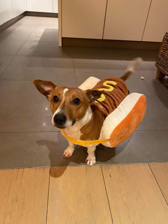

In [26]:
img = PILImage.create(uploader.data[0])
img.to_thumb(224)

In [27]:
pred,_,probs = learn_inf.predict(uploader.data[0])
print(f"Is this a cat?: {pred}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000003


# Excercises

1. Try out the model with a picture of your own dog/cat or with one from the internet
2. Try to build the same model without using any transfer learning (check the `pretrained` parameter of [cnn_learner](https://docs.fast.ai/vision.learner.html#vision_learner))